The task is binary classification on the classic breast-cancer data set shipped with

In [9]:
# 1. Imports

import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# 2. Load data

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
print("Shape:", X.shape, "| Positive class ratio:", y.mean())

Shape: (569, 30) | Positive class ratio: 0.6274165202108963


In [11]:
# 3. Train / test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [12]:
# 4. Build a pipeline
#    - Standardize features
#    - Fit ℓ2-regularized logistic regression
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=200))
])


In [13]:
# 5. Hyper-parameter tuning via cross-validation

param_grid = {
    "clf__C": np.logspace(-3, 3, 7),
    "clf__penalty": ["l2"]
}
grid = GridSearchCV(pipe, param_grid,
                    cv=5, scoring="roc_auc", n_jobs=-1)
grid.fit(X_train, y_train)

print("Best C:", grid.best_params_["clf__C"])
print("CV AUC:", grid.best_score_)

Best C: 0.1
CV AUC: 0.9936016511867904


Test Accuracy: 0.9736842105263158
Test AUC: 0.9957010582010581


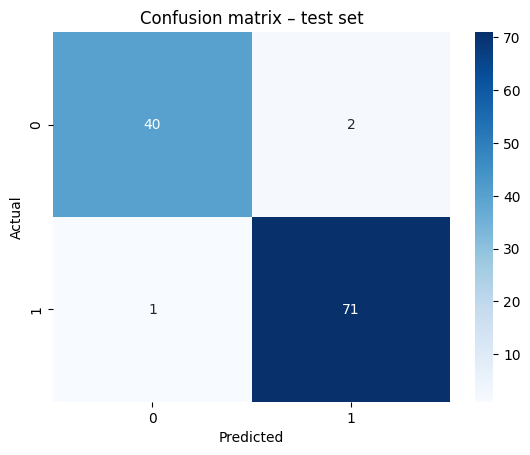

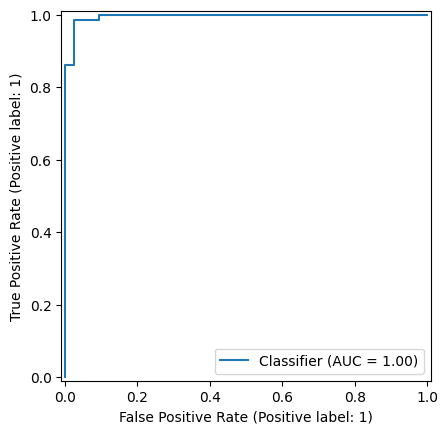

In [14]:
# 6. Evaluate on the held-out test set

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test AUC:", roc_auc_score(y_test, y_prob))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion matrix – test set")
plt.ylabel("Actual"); plt.xlabel("Predicted")
plt.show()

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.show()

In [15]:
# 7. Model interpretation

coef = best_model.named_steps["clf"].coef_[0]
top = pd.Series(coef, index=X.columns).sort_values(key=abs, ascending=False).head(10)
print("Top 10 influential features:")
print(top)

Top 10 influential features:
worst texture          -0.563530
worst radius           -0.509038
worst concave points   -0.507791
worst perimeter        -0.465531
worst area             -0.460311
mean texture           -0.439772
radius error           -0.439074
worst symmetry         -0.412812
mean concave points    -0.403913
mean radius            -0.397267
dtype: float64
